In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import models
import os
import time
from itertools import permutations
import matplotlib.pyplot as plt

gpu_count = torch.cuda.device_count()
print(gpu_count)
for i in range(gpu_count):
    print(torch.cuda.get_device_name(i))

2
GeForce GTX 1080 Ti
GeForce GTX 1080 Ti


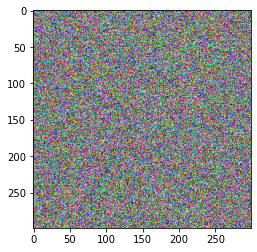

In [2]:
HOME = '/home/jacopo/repo/hshap'

device = "cuda:1"

#LOAD PRE-TRAINED-NETWORK
model = models.inception_v3(pretrained=True)
model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.load_state_dict(torch.load(os.path.join(HOME, 'data/rsna/pretrained-models/RSNA_InceptionV3.pth'), map_location=device))
model.to(device)
model.eval()

input = torch.rand((3, 299, 299))
plt.imshow(input.permute(1, 2, 0))
background = torch.zeros((3, 299, 299))
input = input.to(device)
background = background.to(device)

In [5]:
def generateMasks(M):
    # initialize masks array with all features on -> no need to compute permutations for |S| = M
    masks = np.ones((1, M), dtype=np.bool)
    for i in range(M):
        s = np.zeros(M, dtype=np.bool)
        s[0:i] = 1
        p = permutations(s)
        a = np.array(list(set(p)))
        masks = np.concatenate((masks, a))
    return masks

def maskInput(masks, rootInput, startRow, endRow, startColumn, endColumn):
    d = len(rootInput.shape)
    q = list(np.ones(d+1, dtype=np.integer))
    q[0] = len(masks)
    maskedInputs = rootInput.repeat(q)
    w = endColumn - startColumn
    h = endRow - startRow
    for i, mask in enumerate(masks):
        maskIndices = np.where(mask == 0)[0]
        for index in maskIndices:
            maskStartRow = startRow
            maskEndRow = endRow
            maskStartColumn = startColumn
            maskEndColumn = endColumn
            # First quadrant
            if index == 0:
                maskEndRow = startRow + h / 2
                maskEndColumn = startColumn + w / 2
            # Second quadrant
            elif index == 1:
                maskEndRow = startRow + h / 2
                maskStartColumn += w / 2
            # Third quadrant
            elif index == 2:
                maskStartRow += h / 2
                maskEndColumn = startColumn + w / 2
            # Fourth quadrant
            elif index == 3:
                maskStartRow += h / 2
                maskStartColumn += w / 2
            maskStartRow = int(maskStartRow)
            maskEndRow = int(maskEndRow)
            maskStartColumn = int(maskStartColumn)
            maskEndColumn = int(maskEndColumn)
            maskedInputs[i,
            :, maskStartRow:maskEndRow, maskStartColumn:maskEndColumn
        ] = background[
            :, maskStartRow:maskEndRow, maskStartColumn:maskEndColumn
        ]
    return maskedInputs

masks = generateMasks(4)
maskedInputs = torch.empty(16, 3, 299, 299).to(device)
totevalt = 0
for i, mask in enumerate(masks):
    maskedInputs[i] = maskInput(mask, input, 0, 299, 0, 299)
    t0 = time.time()
    output = model(maskedInputs[i].view(-1, 3, 299, 299))
    t = time.time()
    evalt = t - t0
    totevalt += evalt
print(maskedInputs.size())
print(totevalt * 1e3)
t0 = time.time()
output = model(maskedInputs)
t = time.time()
print((t - t0) * 1e3)
print(output.size())

torch.Size([16, 3, 299, 299])
374.8753070831299
23.41914176940918
torch.Size([16, 2])
